# Micro-ROS Timing Evaluation
This notebook analyzes the timing characteristics of different micro-ROS transports (Serial, UDP) and QoS settings (Best Effort, Reliable) on an ESP32-C6.
The analysis covers synchronization behavior and publishing performance.

In [438]:
import pandas as pd

result_dir = '../results/esp32c6_250518/'

# Sync results
df_sync_serial_115200_10000 = pd.read_csv(result_dir + 'results_sync_serial_115200_10000.csv')
df_sync_udp_10000 = pd.read_csv(result_dir + 'results_sync_udp_10000.csv')

# Pub timer results
df_pub_serial_115200_100ms_10000_best_effort = pd.read_csv(result_dir + 'results_pub_serial_115200_100ms_10000_best_effort.csv')
df_pub_serial_115200_100ms_10000_best_effort_reception = pd.read_csv(result_dir + 'results_pub_serial_115200_100ms_10000_best_effort_reception.csv')

df_pub_serial_115200_100ms_10000_reliable = pd.read_csv(result_dir + 'results_pub_serial_115200_100ms_10000_reliable.csv')
df_pub_serial_115200_100ms_10000_reliable_reception = pd.read_csv(result_dir + 'results_pub_serial_115200_100ms_10000_reliable_reception.csv')

df_pub_udp_100ms_10000_best_effort = pd.read_csv(result_dir + 'results_pub_udp_100ms_10000_best_effort.csv')
df_pub_udp_100ms_10000_best_effort_reception = pd.read_csv(result_dir + 'results_pub_udp_100ms_10000_best_effort_reception.csv')

df_pub_udp_100ms_10000_reliable = pd.read_csv(result_dir + 'results_pub_udp_100ms_10000_reliable.csv')
df_pub_udp_100ms_10000_reliable_reception = pd.read_csv(result_dir + 'results_pub_udp_100ms_10000_reliable_reception.csv')

# Pub fast results
df_pub_serial_115200_max_10000_best_effort = pd.read_csv(result_dir + 'results_pub_serial_115200_max_10000_best_effort.csv')
df_pub_serial_115200_max_10000_best_effort_reception = pd.read_csv(result_dir + 'results_pub_serial_115200_max_10000_best_effort_reception.csv')

df_pub_serial_115200_max_10000_reliable = pd.read_csv(result_dir + 'results_pub_serial_115200_max_10000_reliable.csv')
df_pub_serial_115200_max_10000_reliable_reception = pd.read_csv(result_dir + 'results_pub_serial_115200_max_10000_reliable_reception.csv')

df_pub_udp_max_10000_best_effort = pd.read_csv(result_dir + 'results_pub_udp_max_10000_best_effort.csv')
df_pub_udp_max_10000_best_effort_reception = pd.read_csv(result_dir + 'results_pub_udp_max_10000_best_effort_reception.csv')

df_pub_udp_max_10000_reliable = pd.read_csv(result_dir + 'results_pub_udp_max_10000_reliable.csv')
df_pub_udp_max_10000_reliable_reception = pd.read_csv(result_dir + 'results_pub_udp_max_10000_reliable_reception.csv')

## Sync Data

First, we analyze the synchronization behaviour of the system. For this, we can first determine the time blocked by the sync call. This is needed to estimate how this would affect other tasks in the system and to determine if these calls need to be outsourced to a different task. It is also crucial to have a measure of the clock precision, as the other measurements (see publisher analysis) are based on the a synchronized clock of both the host and the micro-ROS system.
For this, we use the `latency_us` column of the sync data. It containes the time measurement of the call to the following function:
```c
static esp_err_t mros_sync_agent(wallclock_timestamp_t *ts, uint32_t to_ms) {
    if (rmw_uros_sync_session(to_ms * 1000) != RMW_RET_OK || !rmw_uros_epoch_synchronized())
        return ESP_FAIL;
    int64_t n = rmw_uros_epoch_nanos();
    ts->tv_sec = n / 1000000000LL;
    ts->tv_usec = (n % 1000000000LL) / 1000LL;
    return ESP_OK;
}
```

This function uses NTP to synchronize the time to the agent and converts the time to a suitable format.

For analysis, we compute min, max, mean and standard deviation of the latency and plot it as histogram and boxplot.

### Latency

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_experiment_duration(df: pd.DataFrame) -> float:
    # We need to do this check as we reuse the same function for different dataframes
    if 'local_us' in df.columns:
        start_time = df['local_us'].min()
        end_time   = df['local_us'].max()
    else:
        start_time = df['sent_us'].min()
        end_time   = df['sent_us'].max()
    # Return it in seconds
    return (end_time - start_time) / 1e6

def compute_latency_stats(x: np.ndarray):
    x = np.asarray(x)
    if x.size == 0:
        raise ValueError("Empty array")
    mn, mx = x.min(), x.max()
    mu      = x.mean()
    med     = np.median(x)
    var, std= x.var(), x.std()
    # percentiles
    p10, q1, q3, p90 = np.percentile(x, [10,25,75,90])
    count = x.size
    # outliers -> all values outside the 1.5 IQR range
    IQR = q3 - q1
    outliers = np.sum((x < q1 - 1.5 * IQR) | (x > q3 + 1.5 * IQR))
    return {
        'count': count,
        'min':   mn,
        'max':   mx,
        'mean':  mu,
        'median':med,
        'variance': var,
        'std':    std,
        'q1':     q1,
        'q3':     q3,
        'p10':    p10,
        'p90':    p90,
        'outliers': outliers,
        'outliers_ratio': outliers / count,
    }

def stats_to_df(stats: dict) -> pd.DataFrame:
    return pd.DataFrame({
        'count':     [stats['count']],
        'min':       [stats['min']],
        'max':       [stats['max']],
        'mean':      [stats['mean']],
        'median':    [stats['median']],
        'variance':  [stats['variance']],
        'std':       [stats['std']],
        'q1':        [stats['q1']],
        'q3':        [stats['q3']],
        'p10':       [stats['p10']],
        'p90':       [stats['p90']],
        'outliers':  [stats['outliers']],
        'outliers_ratio': [stats['outliers_ratio']],
    })

def plot_latency_distribution(
    x: np.ndarray,
    stats: dict = None,
    title: str  = "Latency Distribution",
    bins: int   = 100,
    color: str  = 'C2',
    median_color: str = 'orange',
    figsize: tuple    = (6,5),
    x_label: str = "Latency (ms)",
    y_label: str = "Count",
):
    if stats is None:
        stats = compute_latency_stats(x)

    # unpack
    mn    = stats['mean']
    med   = stats['median']
    p10   = stats['p10']
    p90   = stats['p90']
    q1, q3= stats['q1'], stats['q3']

    # median style shared by both plots
    medianprops = dict(color=median_color, linestyle='-', linewidth=1.5)

    fig, (ax_hist, ax_box) = plt.subplots(
        nrows=2, sharex=True, figsize=figsize,
        gridspec_kw={'height_ratios':[4,1]},
        constrained_layout=True
    )

    # histogram
    ax_hist.hist(x, bins=bins, color=color, alpha=0.7)
    ax_hist.axvline(mn,   color='k',             linestyle='--', linewidth=2,
                    label=f"Mean = {mn:.3f}")
    ax_hist.axvline(med,  **medianprops,
                    label=f"Median = {med:.3f}")
    ax_hist.axvline(p10,  color='grey', linestyle='--', linewidth=1,
                    label=f"10th Percentile = {p10:.3f}")
    ax_hist.axvline(p90,  color='grey', linestyle='--', linewidth=1,
                    label=f"90th Percentile = {p90:.3f}")
    ax_hist.set_ylabel(y_label)
    ax_hist.tick_params(labelbottom=False)
    ax_hist.legend(loc='upper right', fontsize='small')

    # boxplot
    ax_box.boxplot(
        x,
        vert=False,
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=0.7),
        medianprops=medianprops
    )
    ax_box.set_xlabel(x_label)
    ax_box.set_yticks([])

    fig.suptitle(title, fontweight='bold')
    return fig, (ax_hist, ax_box)


### Sync Data Latency - UART

In [440]:
df_sync_serial_115200_10000.head()

,trial,local_us,remote_us,latency_us,delta_local_us,delta_remote_us,error_us
0,0,1066022,1747574567676857,9036,0,0,0
1,1,1084355,1747574567695677,9334,18333,18820,487
2,2,1102355,1747574567714174,9668,18000,18497,497
3,3,1120355,1747574567731406,9151,18000,17232,-768
4,4,1138355,1747574567749172,8979,18000,17766,-234


In [441]:
duration = compute_experiment_duration(df_sync_serial_115200_10000)
print(f"Experiment duration: {duration:.3f} seconds")

Experiment duration: 180.032 seconds


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10002,8.747,10.836,9.245166,9.278,0.056421,0.237531,9.053,9.416,8.911,9.524,8,0.0008


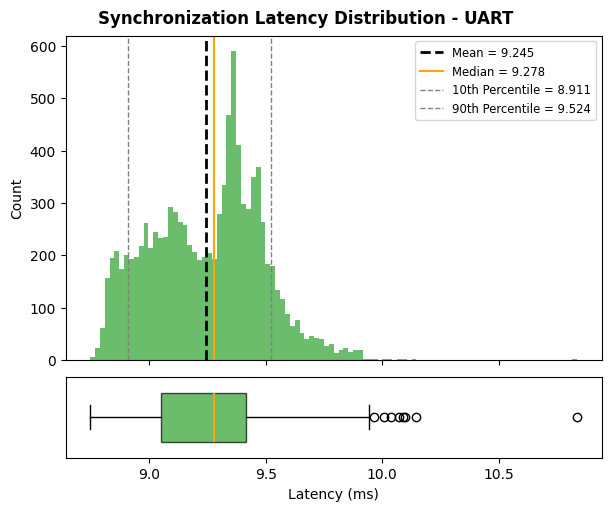

In [442]:
lat_ms = df_sync_serial_115200_10000['latency_us'].to_numpy() * 1e-3

lat_stats = compute_latency_stats(lat_ms)
df_lat_stats = stats_to_df(lat_stats)
display(df_lat_stats)

fig, axes = plot_latency_distribution(
    lat_ms,
    stats=lat_stats,
    title="Synchronization Latency Distribution - UART",
    bins=100,
    color='C2',
    median_color='orange',
)
plt.show()


### Sync Data Latency - UDP

In [443]:
df_sync_udp_10000.head()

,trial,local_us,remote_us,latency_us,delta_local_us,delta_remote_us,error_us
0,0,2692491,1747578820078463,8055,0,0,0
1,1,2710358,1747578820094238,5641,17867,15775,-2092
2,2,2724359,1747578820120740,14337,14001,26502,12501
3,3,2748358,1747578820132143,5761,23999,11403,-12596
4,4,2762359,1747578820146429,6661,14001,14286,285


In [444]:
duration = compute_experiment_duration(df_sync_udp_10000)
print(f"Experiment duration: {duration:.3f} seconds")

Experiment duration: 405.892 seconds


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,4.012,447.888,31.563473,9.621,4174.165166,64.607779,6.54075,19.97425,5.443,49.3422,1196,0.1196


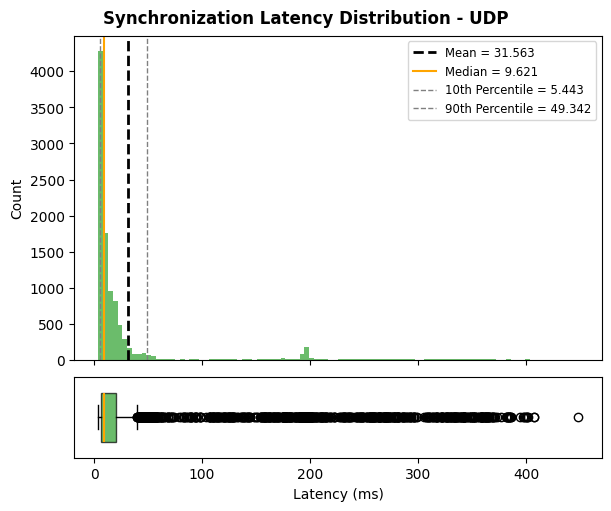

In [445]:
lat_ms = df_sync_udp_10000['latency_us'].to_numpy() * 1e-3

lat_stats = compute_latency_stats(lat_ms)
df_lat_stats = stats_to_df(lat_stats)
display(df_lat_stats)

fig, axes = plot_latency_distribution(
    lat_ms,
    stats=lat_stats,
    title="Synchronization Latency Distribution - UDP",
    bins=100,
    color='C2',
    median_color='orange',
)
plt.show()


### Sync Quality
Now that we have analyzed latency characteristics, we can try to determine synchronization quality. For this, we strongly rely on the slides for `Clock Synchronization` from the `182.713 Echtzeitsysteme` course at TU Wien.
Here, we analyze the following parameters:
- **Clock drift & Drift rate**
- **Drift offset**
- **Delay jitter**

#### Clock Drift & Drift Rate
Based on the following formula, we can determine the clock drift and drift rate:
![182.713 - Formular for Clock Drift & Drift Rate](res/Echtzeitsysteme_Clock_Drift.png "Clock Drift & Drift Rate")

In our case, we have two clocks in our system:
- The clock of the microcontroller
- The clock of the agent
To analyze the drift, we compare the difference of microcontroller time to the difference of agent time.

For this, we use the publish reception measurements on timer basis. This gives us the corresponding time the microcontroller published the message and the time the agent received it. Although this then includes the transmission time, we can still calculate the drift rate, as it corresponds to time differences and not absolute times.

For the formula above, we need the following parameters:
- `t_(i+1) - t_i`: This is the difference of two consecutive agent timestamps. This can easily be calculated from the `recv_us` column of the publish reception data. (assumed to be same as z(microtick)..)
- `g`: This represents the reference clock. In our case, we use the microcontroller clock as reference to the agent clock. In the case of the 100ms timer based publishing on UART transport, we can assume a constant time difference of 100ms, as can be seen by the neglectable standard deviation of the difference in the `sent_us` column:

In [446]:
# First, inspect the structure of the reception data frames
df_pub_serial_115200_100ms_10000_reliable_reception.head()

,trial,sent_us,recv_us,latency_us
0,0,1747601161197723,1747601161204529,6806
1,1,1747601161297695,1747601161302799,5104
2,2,1747601161397695,1747601161404560,6865
3,3,1747601161497695,1747601161504981,7286
4,4,1747601161597695,1747601161604886,7191


In [468]:
runs = {
    'serial_100ms_reliable':    df_pub_serial_115200_100ms_10000_reliable_reception,
    'serial_100ms_best_effort':   df_pub_serial_115200_100ms_10000_best_effort_reception,
    'udp_100ms_best_effort':    df_pub_udp_100ms_10000_best_effort_reception,
    'udp_100ms_reliable':       df_pub_udp_100ms_10000_reliable_reception,
}

def determine_pub_rate(df: pd.DataFrame, name: str):
    dt = df['recv_us'].diff().dropna()
    duration_s = compute_experiment_duration(df)
    return {
        'run'     : name,
        'std_us'  : dt.std(),
        'mean_us' : dt.mean(),
        'rate_hz' : 1 / (dt.mean() * 1e-6),
        'min_us'  : dt.min(),
        'max_us'  : dt.max(),
        'count'   : df.count(), # the initial datapoints
        'duration_s': duration_s,
        'duration_min': duration_s / 60,
    }

rows = []
for name, df in runs.items():
    rows.append(determine_pub_rate(df, name))

pub_rates = pd.DataFrame(rows)
display(pub_rates)

,run,std_us,mean_us,rate_hz,min_us,max_us,count,duration_s,duration_min
0,serial_100ms_reliable,797.403997,100000.117412,9.999988,96517.0,103818.0,trial 10000 sent_us 10000 recv_u...,999.899972,16.665
1,serial_100ms_best_effort,386.307946,100000.345635,9.999965,98032.0,101750.0,trial 10000 sent_us 10000 recv_u...,999.899972,16.665
2,udp_100ms_best_effort,65677.094698,100158.526542,9.984172,80.0,1108619.0,trial 9985 sent_us 9985 recv_us ...,999.900003,16.665
3,udp_100ms_reliable,93194.946632,99999.069907,10.000093,175.0,2859660.0,trial 10000 sent_us 10000 recv_u...,999.899985,16.665


Based on this, we see that only the serial transport provides enough precision to justify the assumption that `g` can be set to a constant of 100ms. While we cannot assume that the UDP transport gives us a valid estimation, the drift rate will be the same, as the drift rate is the same for any transport, as the clocks used are the same.
Now that we know what data is needed, we can calculate the drift rate with the following formula:

In [448]:
def compute_clock_drift(df: pd.DataFrame) -> tuple:
    # We assume g to be constant with a 100 ms period
    g = 100_000 # us
    dt = df['recv_us'].diff().to_numpy()[1:]
    
    drift = dt / g
    drift_rate = abs(drift - 1)

    return drift, drift_rate

We apply this formula to both serial transport measurements and expect to see a similar mean value for both measurements. The standard deviation should be low, as the clock drift should be constant over time.

In [449]:
drift_reliable, drift_rate_timer_reliable = compute_clock_drift(df_pub_serial_115200_100ms_10000_reliable_reception)
drift_best_effort, drift_rate_timer_best_effort = compute_clock_drift(df_pub_serial_115200_100ms_10000_best_effort_reception)

# compute the mean and std of the drift rate
drift_rate_reliable_mean = drift_rate_timer_reliable.mean()
drift_rate_reliable_std  = drift_rate_timer_reliable.std()
drift_rate_best_effort_mean = drift_rate_timer_best_effort.mean()
drift_rate_best_effort_std  = drift_rate_timer_best_effort.std()
print(f"Drift rate (reliable): {drift_rate_reliable_mean:.4f} ± {drift_rate_reliable_std:.3f}")
print(f"Drift rate (best effort): {drift_rate_best_effort_mean:.4f} ± {drift_rate_best_effort_std:.3f}")

Drift rate (reliable): 0.0055 ± 0.006
Drift rate (best effort): 0.0029 ± 0.003


As stated in the slides, a drift rate of `10^-8` to `10^-2` is sensible for real clocks. With our measured `5.5*10^-3` and `2.9*10^-3`, we are in the upper range of this, but still acceptable.

To get a single value for the drift rate, we combine both measurements by calculating mean and std of the combined data:

In [450]:
all_rates = np.concatenate((
    drift_rate_timer_reliable,
    drift_rate_timer_best_effort
))

mean_combined = all_rates.mean()
std_combined  = all_rates.std(ddof=0)

print(f"Estimated drift rate: {mean_combined:.4f} ± {std_combined:.3f}")

Estimated drift rate: 0.0042 ± 0.005


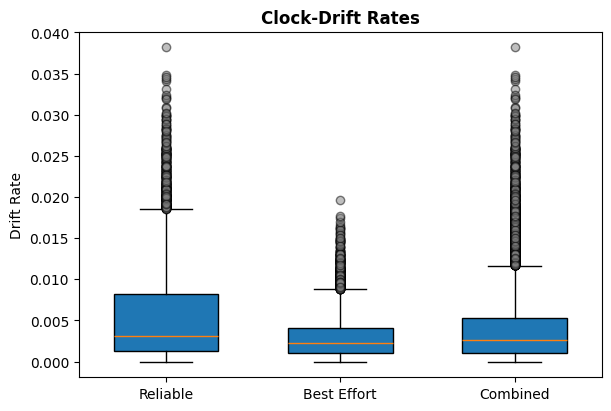

In [451]:
data   = [drift_rate_timer_reliable, drift_rate_timer_best_effort, all_rates]
labels = ['Reliable', 'Best Effort', 'Combined']
colors = ['C2', 'C2', 'C3']

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

bp = ax.boxplot(
    data,
    tick_labels=labels,
    patch_artist=True,
    widths=0.6,
    whiskerprops=dict(color='k'),
    capprops=dict(color='k'),
    flierprops=dict(marker='o', markerfacecolor='grey', alpha=0.5),
)

ax.set_ylabel('Drift Rate')
ax.set_title('Clock-Drift Rates', fontweight='bold')

plt.show()

#### Drift Offset
Now that we have calculated the drift rates, we can apply the following formula to calculate the drift offset:
![182.713 - Formular for Drift Offst](res/Echtzeitsysteme_Internal_Clock_Sync.png "Drift Offset")

As in our case, to determine the drift rate, we used a single synchronization call. The max drift offset then depends on the resynchronization interval and the maximum drift rate. So for the evaluation itself, we cannot give a value for the drift offset, but it will later play a role in the analysis of our more complex system.

Our max then correspond to:

In [452]:
max_drift_rate_reliable = drift_rate_timer_reliable.max()
max_drift_rate_best_effort = drift_rate_timer_best_effort.max()
print(f"Max drift rate (reliable): {max_drift_rate_reliable:.4f}")
print(f"Max drift rate (best effort): {max_drift_rate_best_effort:.4f}")

Max drift rate (reliable): 0.0382
Max drift rate (best effort): 0.0197


To later determine the drift offset, we can use the following method:

In [453]:
def compute_drift_offset(max_drift_rate: float, resync_interval: float) -> float:
    return 2 * max_drift_rate * resync_interval

### Delay Jitter
Based on the slides, another important metric is the delay jitter, calculated as follows:
![182.713 - Formular for Delay Jitter](res/Echtzeitsysteme_Delay_Jitter.png "Delay Jitter")

`d` represents the transmission latency of the synchronization message. In our case, we use the `latency_us` column of the sync data. This represents the complete NTP exchange. We assume this to be our `d` value.
Here we can differentiate between the two transports as this does depend on the transport used.

In [454]:
max_udp    = df_sync_udp_10000['latency_us'].max() * 1e-3
min_udp    = df_sync_udp_10000['latency_us'].min() * 1e-3
jitter_udp = max_udp - min_udp

max_ser    = df_sync_serial_115200_10000['latency_us'].max() * 1e-3
min_ser    = df_sync_serial_115200_10000['latency_us'].min() * 1e-3
jitter_ser = max_ser - min_ser

# build a “tidy” table
latency_jitter_df = pd.DataFrame({
    'Min Latency (ms)':    [min_udp,    min_ser],
    'Max Latency (ms)':    [max_udp,    max_ser],
    'Delay Jitter (ms)':   [jitter_udp, jitter_ser],
}, index=['UDP', 'Serial']).round(3)

latency_jitter_df

,Min Latency (ms),Max Latency (ms),Delay Jitter (ms)
UDP,4.012,447.888,443.876
Serial,8.747,10.836,2.089


As we have already seen in the `Sync Data Latency - UDP` section, the max latency and therefor jitter of the UDP transport is much higher than the latency of the serial transport.

## Publish Data
Now that the sync data is analyzed, we can take a look at the publisher measurements. The test setup is as follows:
- First, the microcontroller and host are synchronized using the analysed sync call from above.
- Then, the microcontroller starts publishing a fixed number of messages (10000).
  - The message is a Uint32_t with the (synchronized) timestamp of the microcontroller at the time of publishing.
  - The publishing is done for both UART and UDP transport and
  - For both a fixed 100ms publish timer and at the maximum possible rate.
  - For both a reliable and best effort QoS.
- The host receives the messages and stores the time of reception.

We can now analyze important aspects of the publish data:
- **Latency**: The time between publishing and receiving the message.
- **Jitter**: The difference maximum and minimum latency.
- **Maximum publishing rate**: The maximum rate at which the microcontroller can publish messages.
- **Message loss**: The number of messages that were not received by the host.

These values are determined for all relevant combinations of transport, publishing rate and QoS.

Let's first see what data is available:

In [455]:
# Firmware side data
df_pub_serial_115200_100ms_10000_best_effort.head()

,trial,local_us,latency
0,0,1747604881919904,154
1,1,1747604882019877,31
2,2,1747604882119876,29
3,3,1747604882219876,26
4,4,1747604882319876,27


In [456]:
# Host side data
df_pub_serial_115200_100ms_10000_best_effort_reception.head()

,trial,sent_us,recv_us,latency_us
0,0,1747604881919904,1747604881925323,5419
1,1,1747604882019877,1747604882025803,5926
2,2,1747604882119876,1747604882125027,5151
3,3,1747604882219876,1747604882225222,5346
4,4,1747604882319876,1747604882325519,5643


In the firmware side data, `local_us` represents the time of publishing and also is the content of the message. Latency represents the time the publish call took. In the host side, we see `recv_us` which is the time of reception and `latency_us` which is the time between publishing and receiving the message.
We can now simply plot the latency for all combinations of transport, publishing rate and QoS.

In [457]:
def analyze_latency(latency_array: np.ndarray, blocking_time_array: np.ndarray, title):
    lat_stats = compute_latency_stats(latency_array)
    df_lat_stats = stats_to_df(lat_stats)
    print(f"Latency stats - {title}")
    display(df_lat_stats)

    # For blocking time, we use the same analysis
    blk_stats = compute_latency_stats(blocking_time_array)
    df_blk_stats = stats_to_df(blk_stats)
    print(f"Blocking time stats - {title}")
    display(df_blk_stats)

    fig, axes = plot_latency_distribution(
        latency_array,
        stats=lat_stats,
        title="Publishing Latency Distribution - " + title,
        bins=100,
        color='C2',
        median_color='orange',
    )
    plt.show()
    
    lat_min = latency_array.min()
    lat_max = latency_array.max()
    lat_jitter = lat_max - lat_min

    df_jitter = pd.DataFrame({
        'min':    [lat_min],
        'max':    [lat_max],
        'jitter': [lat_jitter],
    }, index=[title])

    display(df_jitter)

def check_message_loss(df_send: pd.DataFrame, df_recv: pd.DataFrame) -> float:
    # Check if the two dataframes have the same number of rows
    if df_send.shape[0] != df_recv.shape[0]:
        return ((df_send.shape[0] - df_recv.shape[0]) / df_send.shape[0]) * 100
    else:
        return 0

We can determine how many messages were lost by simply checking the number of messages received and the number of messages sent. Although in the case of reliable QoS, we do not expect any message loss.

### 100ms Timer Based Publishing
#### UART Transport
##### Best Effort QoS

Latency stats - UART - Best Effort


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,5.032,10.032,7.172098,7.187,1.040073,1.01984,6.35475,7.935,5.7839,8.543,0,0.0


Blocking time stats - UART - Best Effort


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,0.026,0.154,0.026014,0.026,0.000002,0.001281,0.026,0.026,0.026,0.026,4,0.0004


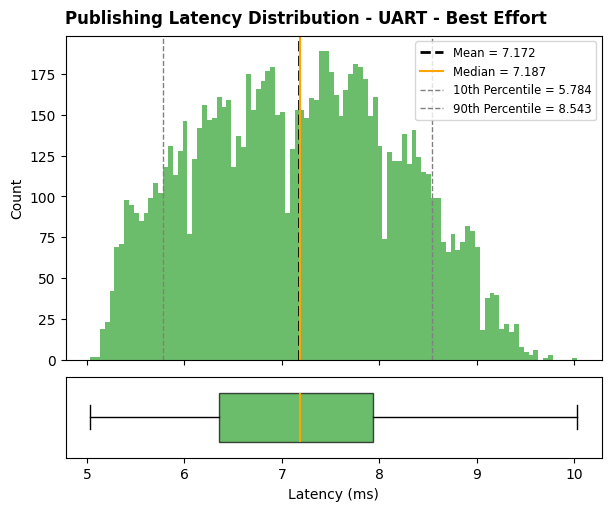

,min,max,jitter
UART - Best Effort,5.032,10.032,5.0


Message loss (UART - Best Effort): 0%


In [458]:
lat_ms = df_pub_serial_115200_100ms_10000_best_effort_reception['latency_us'].to_numpy() * 1e-3
blocking_time_ms = df_pub_serial_115200_100ms_10000_best_effort['latency'].to_numpy() * 1e-3
analyze_latency(lat_ms, blocking_time_ms, "UART - Best Effort")
lost_msgs = check_message_loss(
    df_pub_serial_115200_100ms_10000_best_effort,
    df_pub_serial_115200_100ms_10000_best_effort_reception
)
print(f"Message loss (UART - Best Effort): {lost_msgs}%")

##### Reliable QoS

Latency stats - UART - Reliable


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,5.104,10.806,7.366925,7.338,0.382512,0.618475,7.09975,7.617,6.8949,8.1341,1227,0.1227


Blocking time stats - UART - Reliable


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,7.433,20.073,11.094502,11.004,1.391802,1.179746,10.861,11.375,10.753,12.4751,1863,0.1863


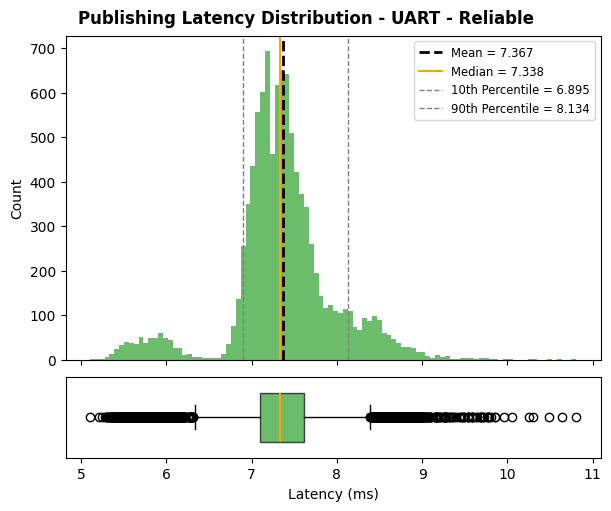

,min,max,jitter
UART - Reliable,5.104,10.806,5.702


Message loss (UART - Reliable): 0%


In [459]:
lat_ms = df_pub_serial_115200_100ms_10000_reliable_reception['latency_us'].to_numpy() * 1e-3
blocking_time_ms = df_pub_serial_115200_100ms_10000_reliable['latency'].to_numpy() * 1e-3
analyze_latency(lat_ms,blocking_time_ms,  "UART - Reliable")
lost_msgs = check_message_loss(
    df_pub_serial_115200_100ms_10000_reliable,
    df_pub_serial_115200_100ms_10000_reliable_reception
)
print(f"Message loss (UART - Reliable): {lost_msgs}%")

#### UDP Transport
##### Best Effort QoS

Latency stats - UDP - Best Effort


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,9985,2.995,1488.837,102.492523,84.334,10759.286288,103.72698,54.077,109.757,25.7416,185.4662,931,0.09324


Blocking time stats - UDP - Best Effort


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,0.348,1.67,0.78046,0.781,0.016105,0.126907,0.73,0.825,0.6099,0.898,1740,0.174


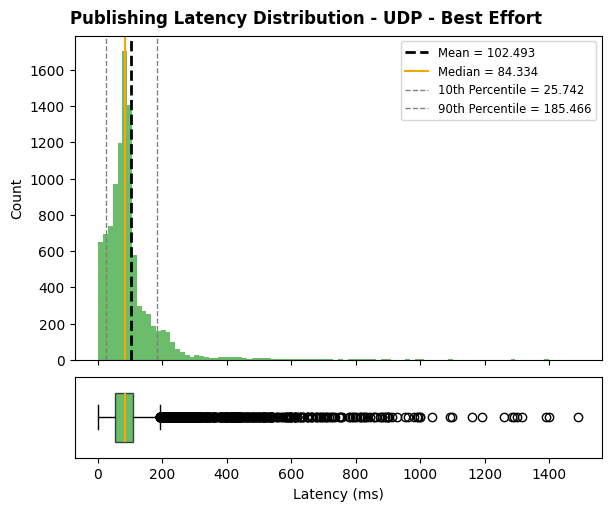

,min,max,jitter
UDP - Best Effort,2.995,1488.837,1485.842


Message loss (UDP - Best Effort): 0.15%


In [460]:
lat_ms = df_pub_udp_100ms_10000_best_effort_reception['latency_us'].to_numpy() * 1e-3
blocking_time_ms = df_pub_udp_100ms_10000_best_effort['latency'].to_numpy() * 1e-3
analyze_latency(lat_ms, blocking_time_ms, "UDP - Best Effort")
lost_msgs = check_message_loss(
    df_pub_udp_100ms_10000_best_effort,
    df_pub_udp_100ms_10000_best_effort_reception
)

print(f"Message loss (UDP - Best Effort): {lost_msgs}%")

##### Reliable QoS

Latency stats - UDP - Reliable


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,-14.254,2760.784,28.629964,3.8725,7829.047537,88.481905,-3.468,21.45375,-7.7411,106.0368,1512,0.1512


Blocking time stats - UDP - Reliable


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,3.14,1001.636,52.964348,23.6095,7659.914391,87.520937,11.966,50.29525,8.0498,147.7184,1399,0.1399


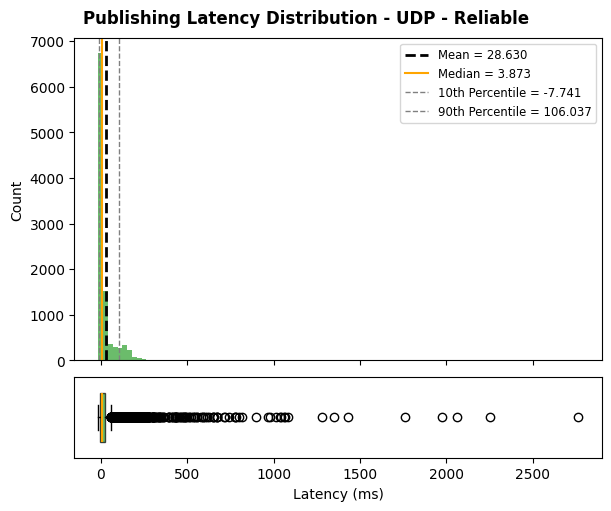

,min,max,jitter
UDP - Reliable,-14.254,2760.784,2775.038


Message loss (UDP - Reliable): 0%


In [461]:
lat_ms = df_pub_udp_100ms_10000_reliable_reception['latency_us'].to_numpy() * 1e-3
blocking_time_ms = df_pub_udp_100ms_10000_reliable['latency'].to_numpy() * 1e-3
analyze_latency(lat_ms, blocking_time_ms, "UDP - Reliable")
lost_msgs = check_message_loss(
    df_pub_udp_100ms_10000_reliable,
    df_pub_udp_100ms_10000_reliable_reception
)

print(f"Message loss (UDP - Reliable): {lost_msgs}%")

The negative latency values are a symptom of the high jitter of the UDP transport. With a delay jitter of `443.876ms` (see `Delay Jitter` section), the UDP synchronization is not precise enough to determine clean latency values. The jitter is agnostic to absolute values, and results in `2.775s` of latency, which is usually not acceptable for real time systems.

### Maximum Rate Publishing
In the case of max rate publishing, in addition to the above metrics, we are also interested in the maximum rate at which publishing is possible. For this, we can also determine min, max, mean and std of the latency values and give an estimation of the maximum rate.
#### UART Transport
##### Best Effort QoS

Latency stats - UART - Best Effort


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,4.117,21.607,12.344646,12.3245,10.793088,3.285284,9.77675,14.92625,7.935,16.764,0,0.0


Blocking time stats - UART - Best Effort


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,0.025,10.257,2.334455,0.025,18.207796,4.267059,0.025,0.026,0.025,10.2,2370,0.237


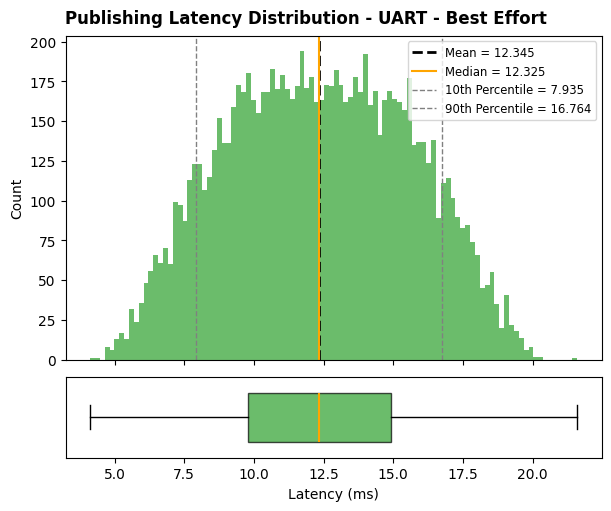

,min,max,jitter
UART - Best Effort,4.117,21.607,17.49


Message loss (UART - Best Effort): 0%


In [462]:
lat_ms = df_pub_serial_115200_max_10000_best_effort_reception['latency_us'].to_numpy() * 1e-3
blocking_time_ms = df_pub_serial_115200_max_10000_best_effort['latency'].to_numpy() * 1e-3
analyze_latency(lat_ms, blocking_time_ms, "UART - Best Effort")
lost_msgs = check_message_loss(
    df_pub_serial_115200_max_10000_best_effort,
    df_pub_serial_115200_max_10000_best_effort_reception
)

print(f"Message loss (UART - Best Effort): {lost_msgs}%")

##### Reliable QoS

Latency stats - UART - Reliable


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,3.797,22.909,11.274987,12.133,11.564204,3.400618,7.791,13.03,6.9,14.5507,25,0.0025


Blocking time stats - UART - Reliable


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,7.784,38.294,17.418763,16.706,22.72757,4.767344,13.42275,21.27125,11.4429,23.0441,61,0.0061


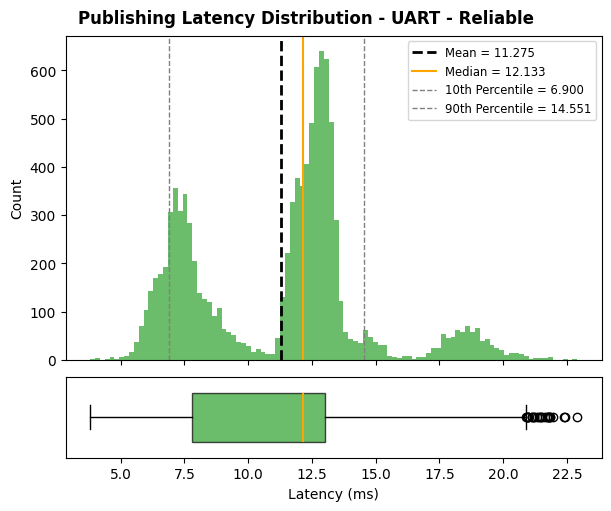

,min,max,jitter
UART - Reliable,3.797,22.909,19.112


Message loss (UART - Reliable): 0%


In [463]:
lat_ms = df_pub_serial_115200_max_10000_reliable_reception['latency_us'].to_numpy() * 1e-3
blocking_time_ms = df_pub_serial_115200_max_10000_reliable['latency'].to_numpy() * 1e-3
analyze_latency(lat_ms, blocking_time_ms, "UART - Reliable")
lost_msgs = check_message_loss(
    df_pub_serial_115200_max_10000_reliable,
    df_pub_serial_115200_max_10000_reliable_reception
)

print(f"Message loss (UART - Reliable): {lost_msgs}%")

We do not see a nice gaussian distribution of the latency values for the reliable QoS. This might be as in the reliable configuration, the microcontroller needs to wait for the acknowledgement of the host, therefore integrating the jitter of the transport and the host.

#### UDP Transport
##### Best Effort QoS

Latency stats - UDP - Best Effort


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,4558,1.498,177.149,21.346817,6.63,1191.739825,34.521585,4.7195,15.537,3.6217,76.2915,756,0.165862


Blocking time stats - UDP - Best Effort


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,0.171,1.197,0.325989,0.282,0.007587,0.087106,0.28,0.39525,0.273,0.419,240,0.024


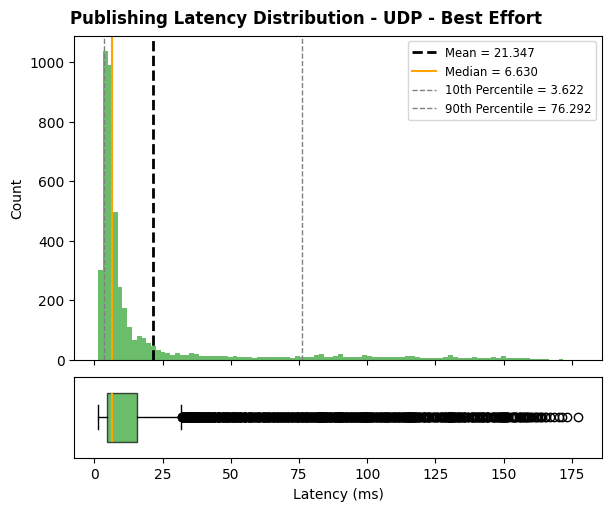

,min,max,jitter
UDP - Best Effort,1.498,177.149,175.651


Message loss (UDP - Best Effort): 54.42%


In [464]:
lat_ms = df_pub_udp_max_10000_best_effort_reception['latency_us'].to_numpy() * 1e-3
blocking_time_ms = df_pub_udp_max_10000_best_effort['latency'].to_numpy() * 1e-3
analyze_latency(lat_ms, blocking_time_ms, "UDP - Best Effort")
lost_msgs = check_message_loss(
    df_pub_udp_max_10000_best_effort,
    df_pub_udp_max_10000_best_effort_reception
)

print(f"Message loss (UDP - Best Effort): {lost_msgs}%")

##### Reliable QoS

Latency stats - UDP - Reliable


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,-6.451,301.091,9.25664,2.6735,724.798382,26.92208,-0.39775,8.48325,-2.5035,18.4655,736,0.0736


Blocking time stats - UDP - Reliable


,count,min,max,mean,median,variance,std,q1,q3,p10,p90,outliers,outliers_ratio
0,10000,4.935,485.416,21.04088,12.244,943.636463,30.718666,9.207,21.7155,7.7539,33.1404,604,0.0604


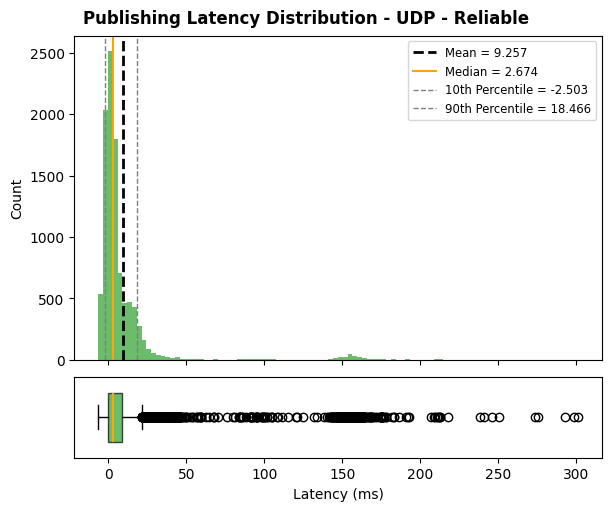

,min,max,jitter
UDP - Reliable,-6.451,301.091,307.542


Message loss (UDP - Reliable): 0%


In [465]:
lat_ms = df_pub_udp_max_10000_reliable_reception['latency_us'].to_numpy() * 1e-3
blocking_time_ms = df_pub_udp_max_10000_reliable['latency'].to_numpy() * 1e-3
analyze_latency(lat_ms, blocking_time_ms, "UDP - Reliable")
lost_msgs = check_message_loss(
    df_pub_udp_max_10000_reliable,
    df_pub_udp_max_10000_reliable_reception
)

print(f"Message loss (UDP - Reliable): {lost_msgs}%")

Here again, we see negative latency values, presumably due the high jitter of the UDP synchronization.

### Publish Rates

To determine the publish rate, we take the difference of the reception timestamps and again calculate the min, max, mean and std of the difference.

In [470]:
# We reuse the drift rate publish rate method
runs = {
    'serial_max_reliable':    df_pub_serial_115200_max_10000_reliable_reception,
    'serial_max_best_effort':  df_pub_serial_115200_max_10000_best_effort_reception,
    'udp_max_best_effort':     df_pub_udp_max_10000_best_effort_reception,
    'udp_max_reliable':        df_pub_udp_max_10000_reliable_reception,
}

# compute publish rates
rows = []
for name, df in runs.items():
    rows.append(determine_pub_rate(df, name))
pub_rates = pd.DataFrame(rows)

# compute message loss
lost_msgs = {
    'serial_max_reliable':    check_message_loss(
        df_pub_serial_115200_max_10000_reliable,
        df_pub_serial_115200_max_10000_reliable_reception
    ),
    'serial_max_best_effort': check_message_loss(
        df_pub_serial_115200_max_10000_best_effort,
        df_pub_serial_115200_max_10000_best_effort_reception
    ),
    'udp_max_best_effort':    check_message_loss(
        df_pub_udp_max_10000_best_effort,
        df_pub_udp_max_10000_best_effort_reception
    ),
    'udp_max_reliable':       check_message_loss(
        df_pub_udp_max_10000_reliable,
        df_pub_udp_max_10000_reliable_reception
    ),
}

# merge loss into pub_rates
pub_rates['message_loss_%'] = pub_rates['run'].map(lost_msgs)

display(pub_rates)

,run,std_us,mean_us,rate_hz,min_us,max_us,count,duration_s,duration_min,message_loss_%
0,serial_max_reliable,4750.039705,17432.748875,57.363300,9615.0,35187.0,trial 10000 sent_us 10000 recv_u...,174.310897,2.905182,0.00
1,serial_max_best_effort,2382.512184,2347.878988,425.916329,80.0,8790.0,trial 10000 sent_us 10000 recv_u...,23.478532,0.391309,0.00
2,udp_max_best_effort,6808.946478,762.190696,1312.007619,70.0,174240.0,trial 4558 sent_us 4558 recv_us ...,3.446144,0.057436,54.42
3,udp_max_reliable,28566.872500,21052.265227,47.500827,202.0,428308.0,trial 10000 sent_us 10000 recv_u...,210.550928,3.509182,0.00


##### Bitrate
To determine the bitrate, we simply multiply the publish rate with the bit count in the message. In our case, the message is a `Uint64_t` with 8 bytes. So the bitrate is simply `8 * 8 * publish rate`.

In [467]:
# In our case, we have a 8 byte message
S_byte = 8
S_bit = S_byte * 8

# pub_rates run column -> serial_max_reliable -> we need the rate_hz column
serial_max_best_effort_bitrate = pub_rates.loc[pub_rates['run'] == 'serial_max_best_effort', 'rate_hz'].values[0] * S_bit
serial_max_reliable_bitrate = pub_rates.loc[pub_rates['run'] == 'serial_max_reliable', 'rate_hz'].values[0] * S_bit
udp_max_best_effort_bitrate = pub_rates.loc[pub_rates['run'] == 'udp_max_best_effort', 'rate_hz'].values[0] * S_bit
udp_max_reliable_bitrate = pub_rates.loc[pub_rates['run'] == 'udp_max_reliable', 'rate_hz'].values[0] * S_bit

# Build a “tidy” table
bitrate_df = pd.DataFrame({
    'Bitrate (bps)':    [serial_max_best_effort_bitrate, serial_max_reliable_bitrate, udp_max_best_effort_bitrate, udp_max_reliable_bitrate],
}, index=['Serial - Best Effort', 'Serial - Reliable', 'UDP - Best Effort', 'UDP - Reliable']).round(3)
bitrate_df


,Bitrate (bps)
Serial - Best Effort,27258.645
Serial - Reliable,3671.251
UDP - Best Effort,83968.488
UDP - Reliable,3040.053


This shows that even for a 115200 baud UART connection, the effective bitrate for a single 8 byte message is only `27.258kbit/s` for best effort QoS and an even lower `3.671kbit/s` for reliable QoS. The throughput can of course be increased by packing more data into a single message, but this is not the topic of this evaluation. While the UDP transport with best effort QoS achieves a seemingly higher throughput, the jitter and message loss makes it hard to provide any timing guarantees.